# Adversarie Attack on Fashion MNIST

Este experimento se llevó a cabo con la intención de comprobar la transferibilidad de adversarial examples de un modelo a otro cuando ambos modelos poseen el mismo tipo de clasificación

In [66]:

# import the needed packages
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
from tensorflow import keras
from pylab import *
from numpy.random import seed
import matplotlib as mpl
import numpy as np
# to load
from keras.models import load_model
from keras.models import model_from_json
import json
import random

# Con sed hacemos reproducible algunos de los resultados
seed(1)


Configuración necesaria para ejecución en GPU con tarjeta grafica Nvidia GTX 1650 y para permitir uso de memoria

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Importamos las imágenes a procesar con keras.  
Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Matriz con mapeo de clasificaciones

In [5]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

In [53]:
# Variables para mostrar resuldatosm imagenes
mpl.rcParams['figure.figsize'] = (1.8, 1.8)
mpl.rcParams['axes.grid'] = False

Las imágenes son en escala de grises tamaño 28x28. Visualizamos algunas imágenes:

In [7]:
# Agregamos una dimensión a los datos
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

Normalizamos las imágenes

In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Nombre corto para clase ImageDataGenerator

In [9]:
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

Definimos una función para la visualización de gráficos

In [10]:
#normalize
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
 #   validation_split = 0.2,
)

Hiperparametros

In [11]:
epoch=15
batch_size = 32
height, width = (28,28)
steps_per_epoch = 1875 #60000/batch_size
learning_rate = 0.001


## MODEL_01: Modelo sustituto
Nuestro modelo base, red convolutiva con funciones relu 

In [12]:
model_01 = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model_01.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model_01.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_01.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_01.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_01.add(tf.keras.layers.Flatten())
model_01.add(tf.keras.layers.Dense(124, activation='relu'))
model_01.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model_01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 124)               194556    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [13]:

model_01.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [14]:
start_time = time.time()
history_01 = model_01.fit(
    x_train,y_train,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 31s 516us/sample - loss: 0.5059 - acc: 0.8189 - val_loss: 0.3774 - val_acc: 0.8657
Epoch 2/15
60000/60000 [==============================] - 25s 410us/sample - loss: 0.3497 - acc: 0.8747 - val_loss: 0.3371 - val_acc: 0.8773
Epoch 3/15
60000/60000 [==============================] - 23s 384us/sample - loss: 0.3062 - acc: 0.8909 - val_loss: 0.3156 - val_acc: 0.8866
Epoch 4/15
60000/60000 [==============================] - 25s 422us/sample - loss: 0.2773 - acc: 0.8999 - val_loss: 0.2941 - val_acc: 0.8917
Epoch 5/15
60000/60000 [==============================] - 24s 397us/sample - loss: 0.2573 - acc: 0.9069 - val_loss: 0.3273 - val_acc: 0.8791
Epoch 6/15
60000/60000 [==============================] - 24s 397us/sample - loss: 0.2410 - acc: 0.9125 - val_loss: 0.2848 - val_acc: 0.8977
Epoch 7/15
60000/60000 [==============================] - 23s 385us/sample - loss: 0.2269 - acc: 0.9176 

In [14]:
# serialize weights to HDF5

model_json = model_01.to_json()
with open("model_in_json.json", "w") as json_file:
    #json.dump(model_json, json_file)
    json_file.write(model_json)
model_01.save_weights("fashion_model01.h5")


# Adversarie example

In [27]:
# Función que entrega la etiqueta y probabilidad -> decode de respuesta
def get_imagenet_label(probs):
  result = np.where(probs[0] == np.amax(probs[0]))
  max_index = result[0][0]
  probabilidad=probs[0][max_index]
  label = fashion_mnist_labels[max_index] 
  #return  str(label) + " con probabilidad: " + str(probabilidad)
  return  "",label, probabilidad


In [22]:
# Se elije la imagen de entrenamiento para crear adversarial example
index_image=995 #997 coat
image=x_test[index_image]
image_index_class = y_test[index_image]
image_tf = tf.convert_to_tensor(image, dtype=tf.float32)
#plt.imshow(np.squeeze(image))
#print(fashion_mnist_labels[image_index_class])

In [23]:
image_tf_a = image_tf[None, ...]
image_probs = model_01.predict(image_tf_a)

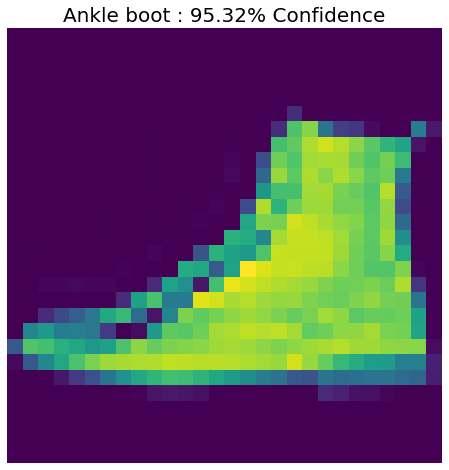

In [18]:
plt.figure()
plt.imshow(np.squeeze(image_tf_a[0]))
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100), fontsize=20)
plt.axis(False)
plt.show()

In [70]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model_01(input_image)
    loss = loss_object(input_label, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [20]:

label = tf.one_hot(image_index_class, image_probs.shape[-1]) #image_probs.shape[-1] = 1.000
label.shape

TensorShape([10])

In [21]:
label = tf.reshape(label, (1, image_probs.shape[-1]))


In [22]:
from __future__ import print_function

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [23]:
prediction_x = model_01(image_tf_a)
lost_x = loss_object(label, prediction_x)
lost_x

<tf.Tensor: shape=(), dtype=float32, numpy=0.04794681>

In [25]:
#perturbations = create_adversarial_pattern(image, label)
#image = image[None, ...]

perturbations = create_adversarial_pattern(image_tf_a, label)
#plt.imshow(np.squeeze(perturbations[0]))
#print(np.squeeze(perturbations[0]))

(-0.5, 27.5, 27.5, -0.5)

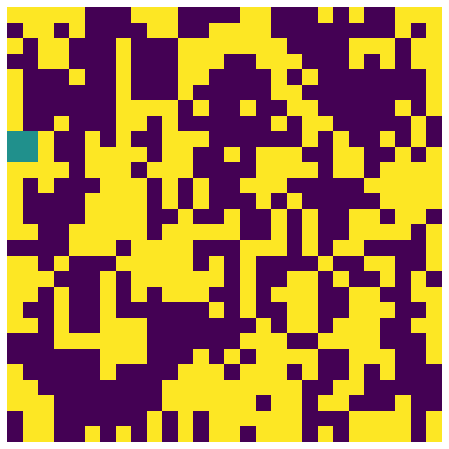

In [26]:
plt.imshow(np.squeeze(perturbations[0]))
plt.axis(False)

In [45]:
def display_images(image, description, model):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  #plt.imshow(image[0])
  plt.imshow(np.squeeze(image[0]))
  plt.title('{} \n {} : {:.2f}%'.format(description,
                                                   label, confidence*100),
                                                   fontsize=10)
  plt.axis(False)
  plt.show()

In [19]:
epsilons = [0, 0.025, 0.05, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

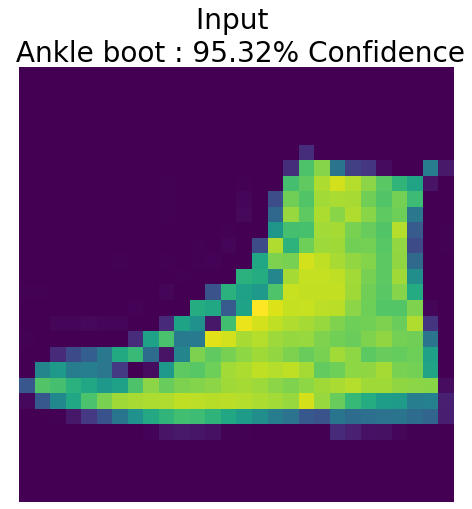

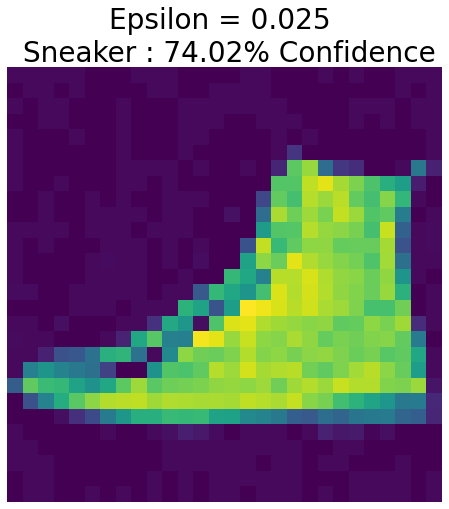

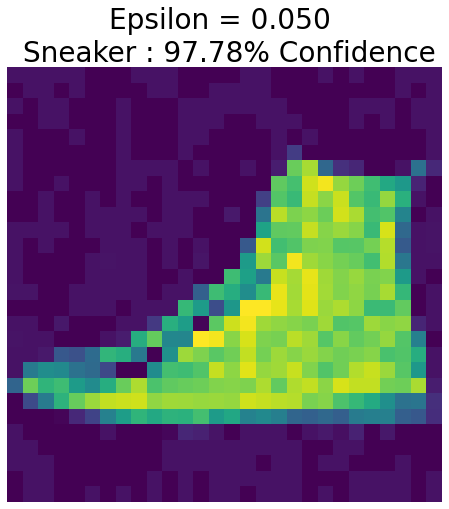

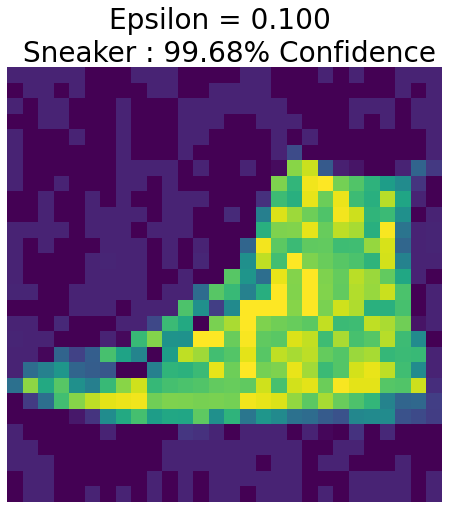

In [368]:
# empty array
adv_x_arr = [] 
for i, eps in enumerate(epsilons):
  adv_x = image_tf_a + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i], model_01)
  adv_x_arr.append(adv_x)
  

Hiper Parametros

In [30]:
epoch=15
batch_size = 32
height, width = (28,28)
steps_per_epoch = 1875 #60000/batch_size
learning_rate = 0.001

## Data augmentation
Modificamos las imagenes de entrenamiento aleatoriamente para poseer mayor cantidad de datos de entrenamiento. Transformaciones:zoom, rotár, ajuste de medidas y flip horizontal. 

In [31]:
# Parametro de data argumentation
shift_fraction=0.005
# Data argumentation
datagen = ImageDataGenerator(        
        width_shift_range= shift_fraction,
        height_shift_range= shift_fraction,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=True,
        vertical_flip=False, 
)



In [32]:
batches = datagen.flow(x_train, y_train, batch_size=batch_size)


# Mejoras de la red

# MODEL_02  
Implementamos un modelo con una capa oculta extra y con más neuronas


In [33]:
model_02 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='relu'),
        
        keras.layers.Dense(512, activation='relu'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_02.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)      

In [34]:

model_02.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [35]:
start_time = time.time()
history_02 = model_02.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.4081 - acc: 0.8482 - val_loss: 0.3142 - val_acc: 0.8817
Epoch 2/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2733 - acc: 0.8994 - val_loss: 0.2859 - val_acc: 0.8972
Epoch 3/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2299 - acc: 0.9170 - val_loss: 0.2512 - val_acc: 0.9094
Epoch 4/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2024 - acc: 0.9256 - val_loss: 0.2468 - val_acc: 0.9119
Epoch 5/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1820 - acc: 0.9319 - val_loss: 0.2120 - val_acc: 0.9234
Epoch 6/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1668 - acc: 0.9369 - val_loss: 0.2051 - val_acc: 0.9258
Epoch 7/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1536 - acc: 0.9437 - val_loss: 

## modelo_03
Sumamos otra capa oculta, cambiando el numero de neuronas para observar nuevos resultados

In [36]:
model_03 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='relu'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_03.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 13, 128)      

In [37]:
model_03.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [38]:
start_time = time.time()
history_03 = model_03.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.5438 - acc: 0.8037 - val_loss: 0.3396 - val_acc: 0.8765
Epoch 2/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.3371 - acc: 0.8806 - val_loss: 0.2810 - val_acc: 0.8996
Epoch 3/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2833 - acc: 0.9003 - val_loss: 0.2599 - val_acc: 0.9081
Epoch 4/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2478 - acc: 0.9112 - val_loss: 0.2291 - val_acc: 0.9174
Epoch 5/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2271 - acc: 0.9193 - val_loss: 0.2204 - val_acc: 0.9197
Epoch 6/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2083 - acc: 0.9262 - val_loss: 0.2343 - val_acc: 0.9139
Epoch 7/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1937 - acc: 0.9302 - val_loss: 

## Modelo 04 sigmoid

In [39]:
model_04 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='sigmoid'),
        
        keras.layers.Dense(512, activation='sigmoid'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_04.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 13, 13, 128)      

In [40]:
model_04.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [41]:
start_time = time.time()
history_04 = model_04.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4087 - acc: 0.8504 - val_loss: 0.3526 - val_acc: 0.8680
Epoch 2/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2686 - acc: 0.9018 - val_loss: 0.3105 - val_acc: 0.8880
Epoch 3/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2312 - acc: 0.9144 - val_loss: 0.2642 - val_acc: 0.9043
Epoch 4/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2032 - acc: 0.9245 - val_loss: 0.2577 - val_acc: 0.9090
Epoch 5/15
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1852 - acc: 0.9319 - val_loss: 0.2119 - val_acc: 0.9216
Epoch 6/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1709 - acc: 0.9363 - val_loss: 0.2000 - val_acc: 0.9278
Epoch 7/15
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1586 - acc: 0.9417 - val_loss: 

## Modelo 05 sigmoid + dropout

In [42]:


model_05 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_05.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 13, 13, 128)      

In [43]:
model_05.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [44]:
start_time = time.time()
history_05 = model_05.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4584 - acc: 0.8370 - val_loss: 0.3199 - val_acc: 0.8809
Epoch 2/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2853 - acc: 0.8983 - val_loss: 0.2480 - val_acc: 0.9088
Epoch 3/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2471 - acc: 0.9122 - val_loss: 0.2400 - val_acc: 0.9132
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2180 - acc: 0.9224 - val_loss: 0.2239 - val_acc: 0.9178
Epoch 5/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1968 - acc: 0.9294 - val_loss: 0.2066 - val_acc: 0.9234
Epoch 6/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1819 - acc: 0.9346 - val_loss: 0.2145 - val_acc: 0.9243
Epoch 7/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1692 - acc: 0.9392 - val_loss: 

## Modelo 06 sigmoid y relu

In [45]:
model_06 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(512, activation='relu'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='sigmoid'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='sigmoid'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_06.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 256)       147712    
_________________________________________________________________
batch_normalization_26 (Batc (None, 13, 13, 256)      

In [46]:
model_06.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [47]:
start_time = time.time()
history_06 = model_06.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 62s 33ms/step - loss: 0.4179 - acc: 0.8504 - val_loss: 0.2809 - val_acc: 0.8994
Epoch 2/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2762 - acc: 0.8997 - val_loss: 0.2427 - val_acc: 0.9104
Epoch 3/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2336 - acc: 0.9146 - val_loss: 0.2466 - val_acc: 0.9081
Epoch 4/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2044 - acc: 0.9249 - val_loss: 0.2431 - val_acc: 0.9097
Epoch 5/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1835 - acc: 0.9329 - val_loss: 0.1972 - val_acc: 0.9300
Epoch 6/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1640 - acc: 0.9395 - val_loss: 0.2000 - val_acc: 0.9305
Epoch 7/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1480 - acc: 0.9453 - val_loss: 

# Adversary Attack en modelos  Objetivos
Utilizamos las imagenes generadas con la tecnica FGSM a partir del modelo sustituto para atacar como caja negra los modelos del 02 al 06


### Atacando al modelo 02

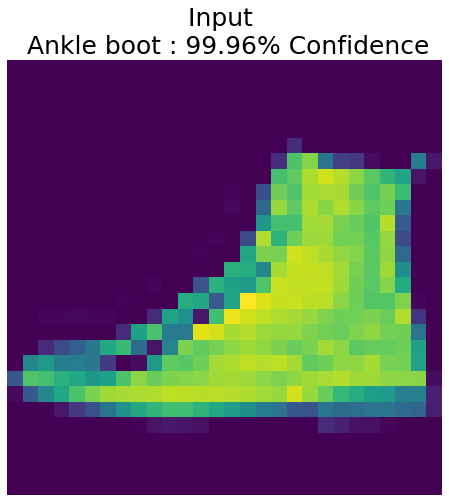

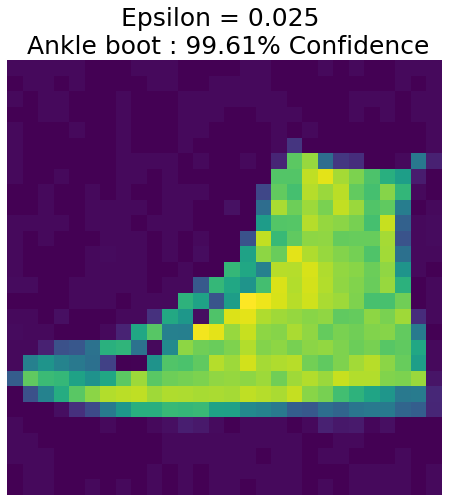

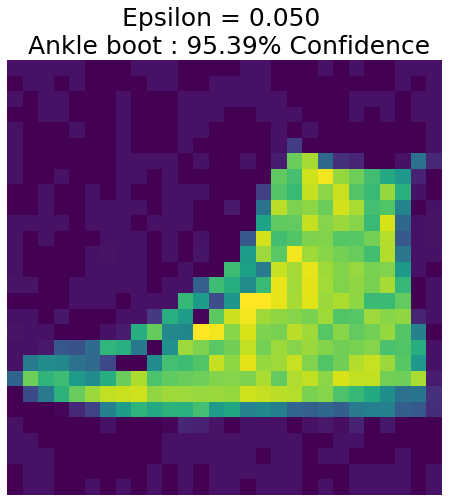

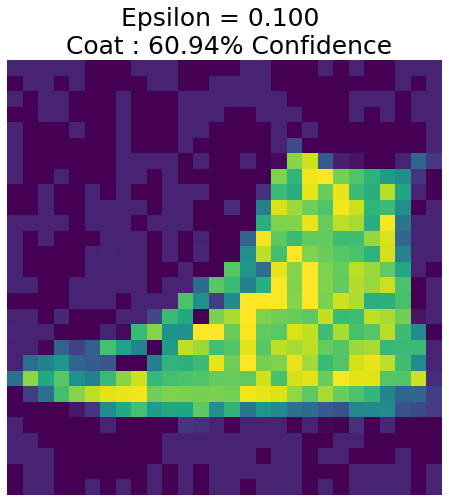

In [48]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_02)
  

### Atacando al modelo 03

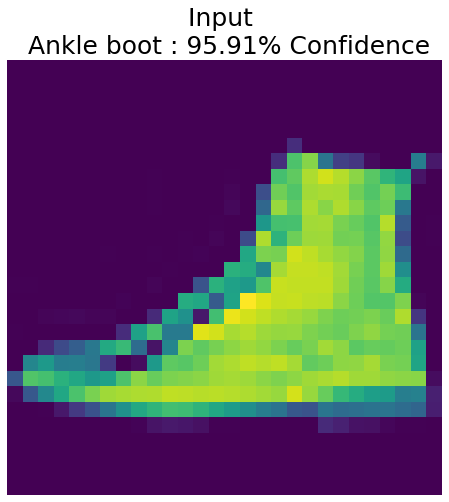

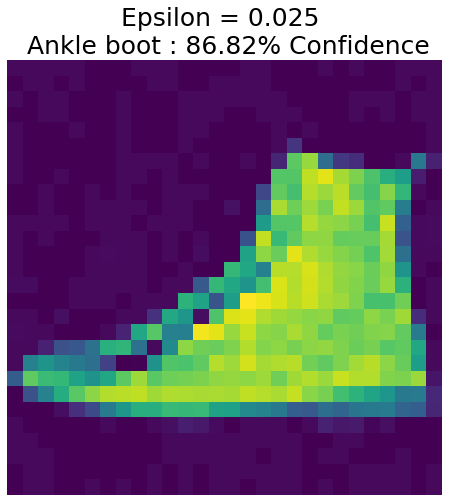

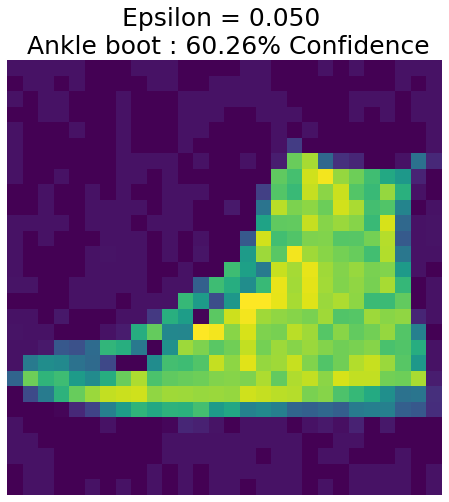

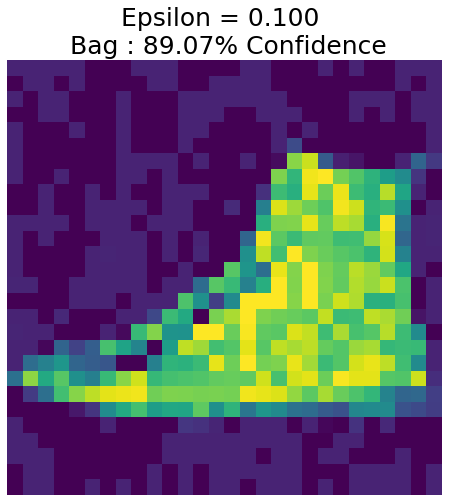

In [49]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_03)

### Atacando al modelo 04

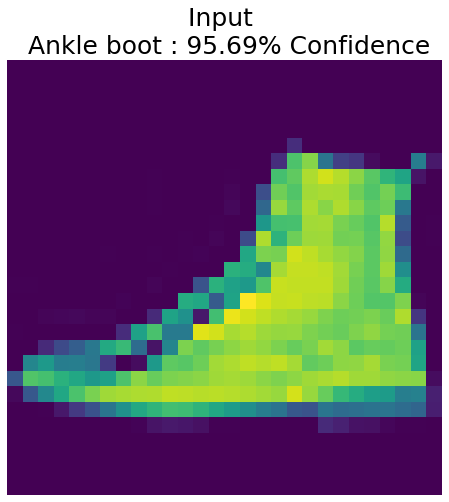

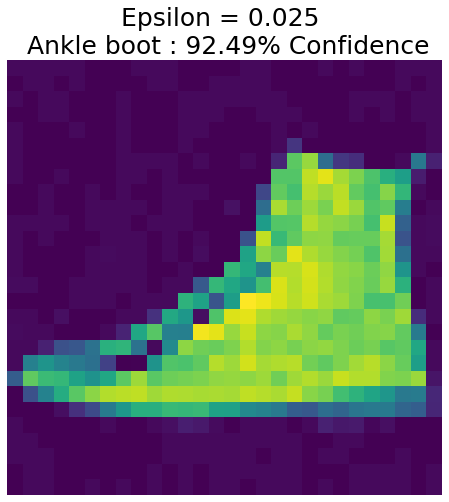

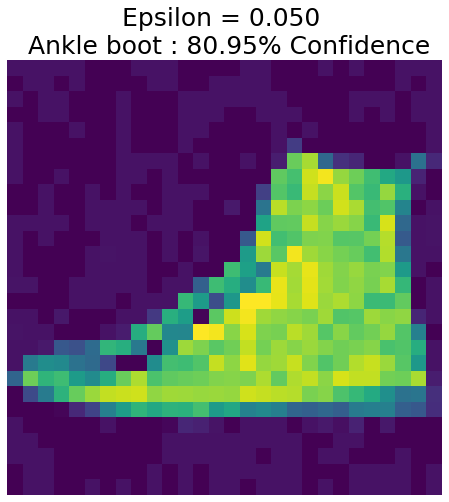

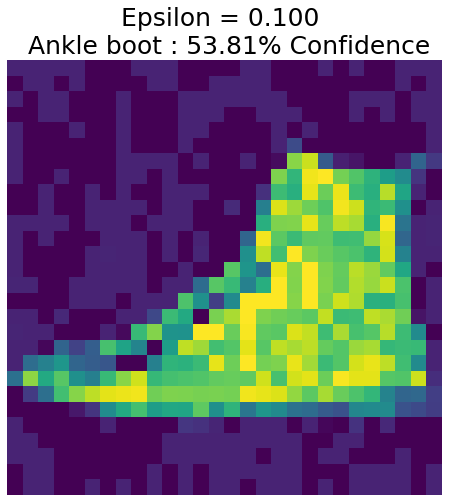

In [50]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_04)

### Atacando al modelo 05

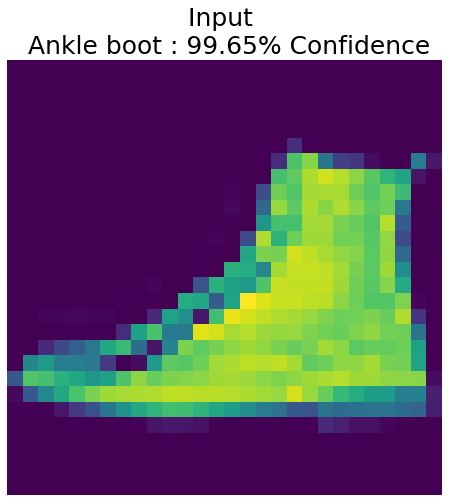

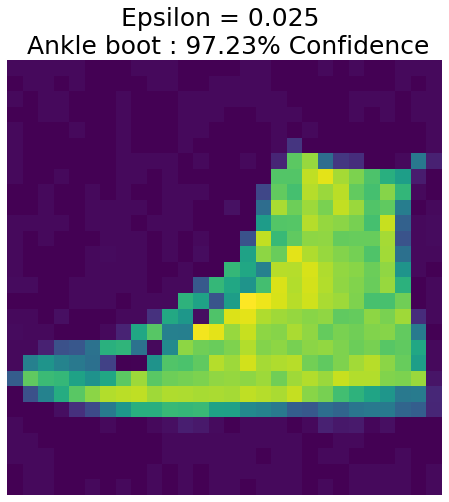

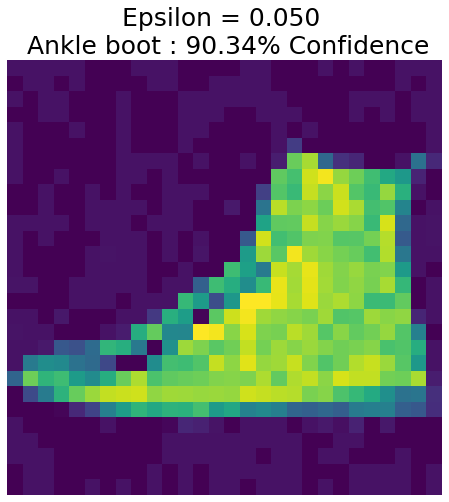

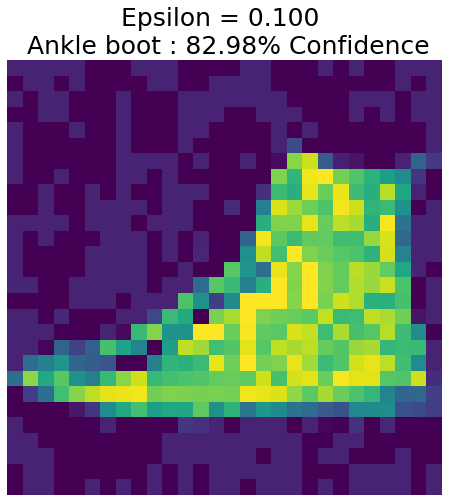

In [51]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_05)

### Atacando al modelo 06

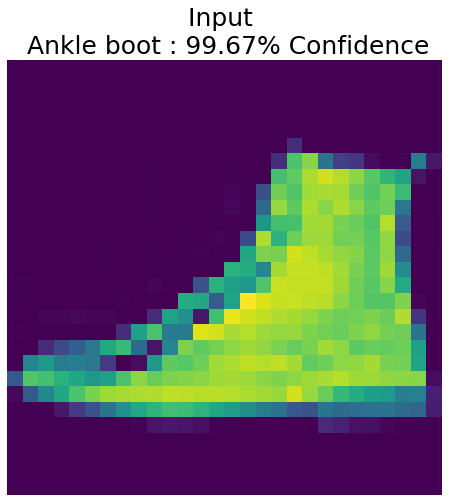

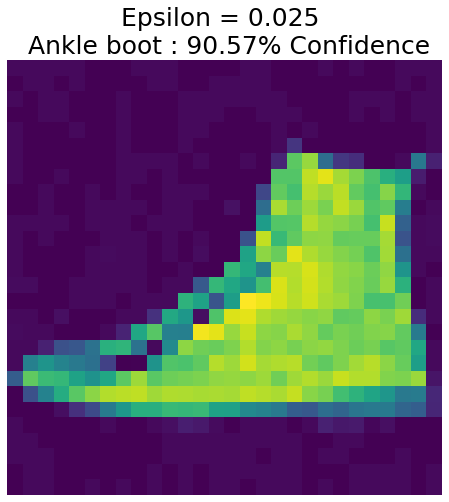

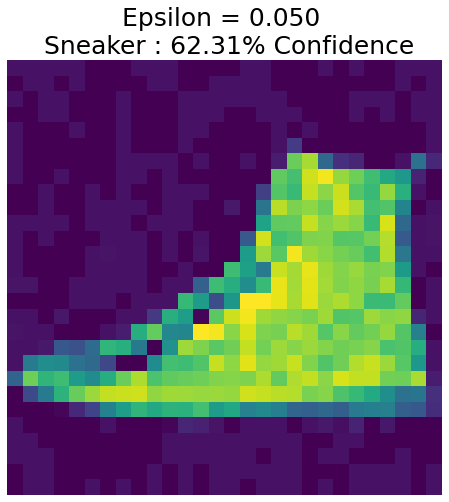

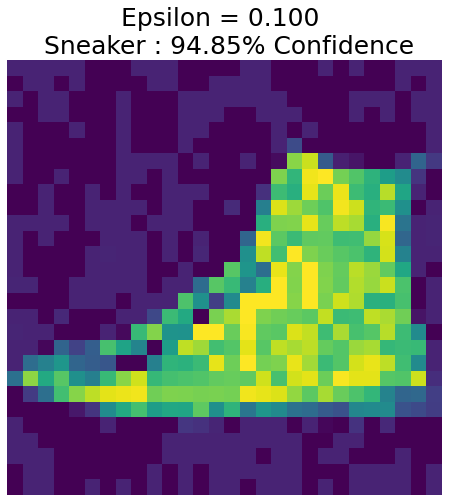

In [52]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_06)

# Resultados  
Se comprueba la propiedad de transferibilidad de imágenes adversarias generadas en un modelo sustituto creado  para atacar a otros modelos a los cuales solo se accede como caja negra.


# Segundo ataque

elección de imagen a convertir en adversarial example

index: 98 Clase: 2 Prob:0.80813175


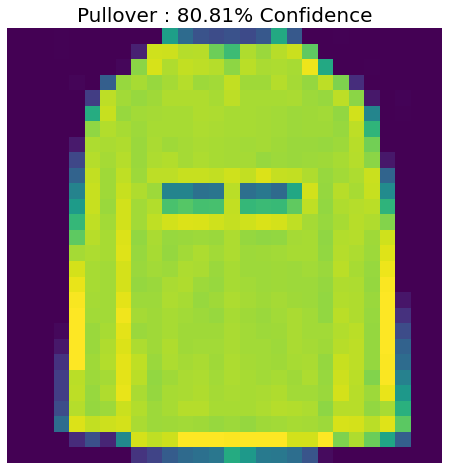

index: 117 Clase: 4 Prob:0.8297404


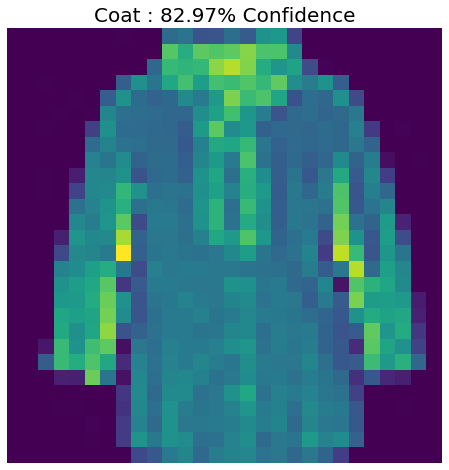

index: 217 Clase: 6 Prob:0.80585605


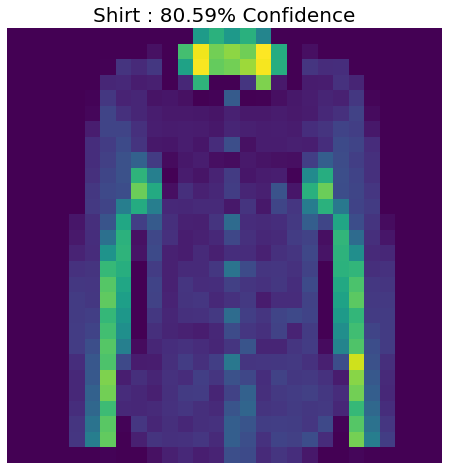

index: 255 Clase: 2 Prob:0.82707083


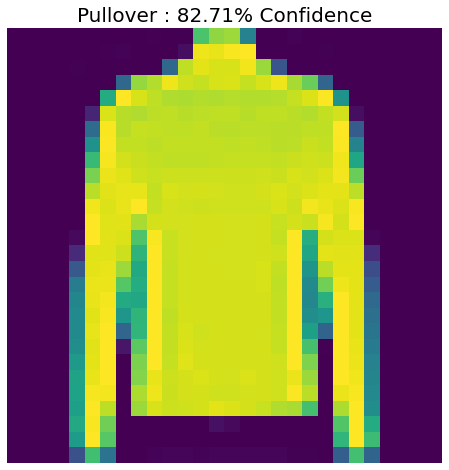

index: 359 Clase: 0 Prob:0.8199096


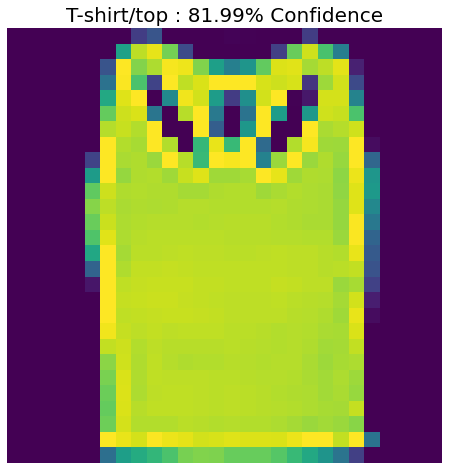

index: 361 Clase: 2 Prob:0.82737553


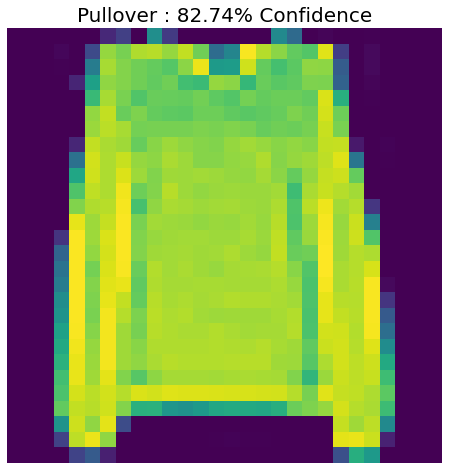

index: 395 Clase: 0 Prob:0.82519823


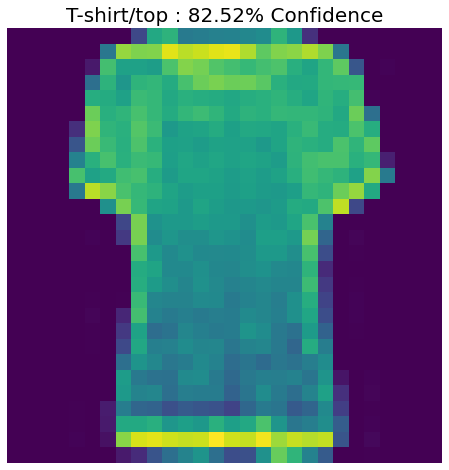

index: 407 Clase: 6 Prob:0.80485404


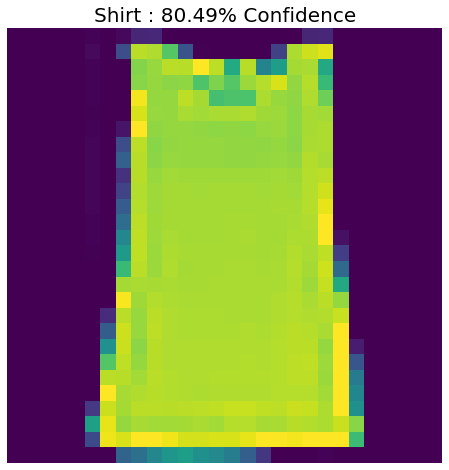

index: 419 Clase: 4 Prob:0.8202661


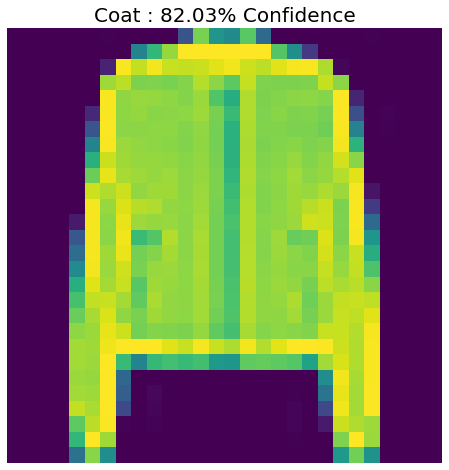

index: 498 Clase: 7 Prob:0.804315


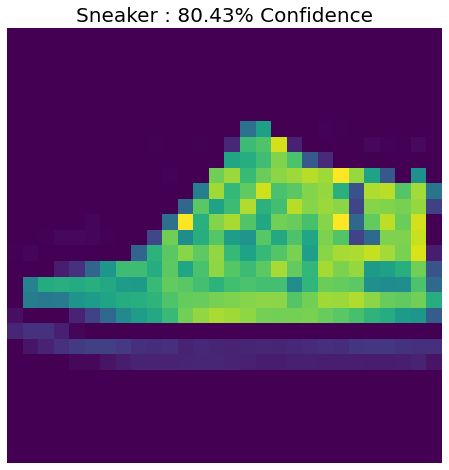

index: 674 Clase: 3 Prob:0.8144336


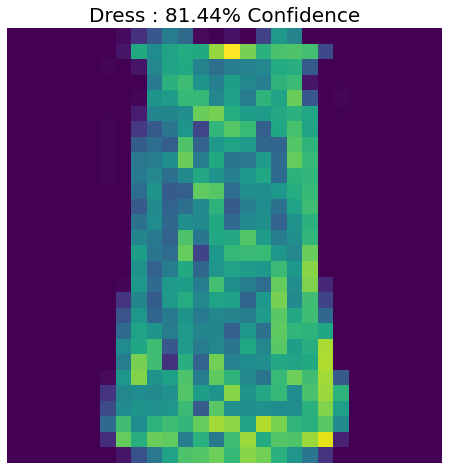

index: 713 Clase: 3 Prob:0.8267597


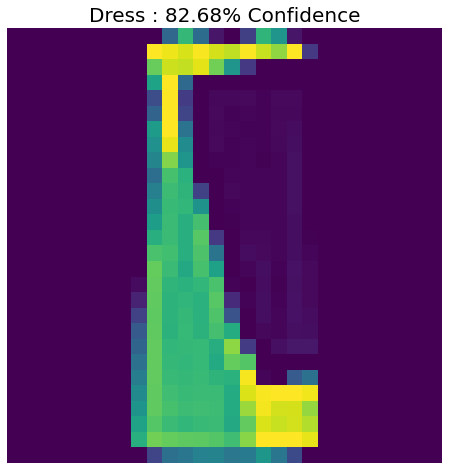

index: 717 Clase: 7 Prob:0.8055787


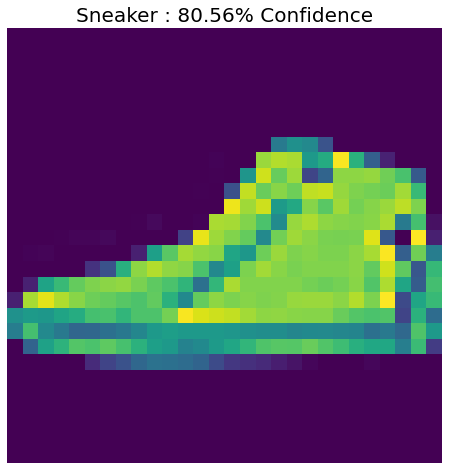

index: 753 Clase: 2 Prob:0.8067681


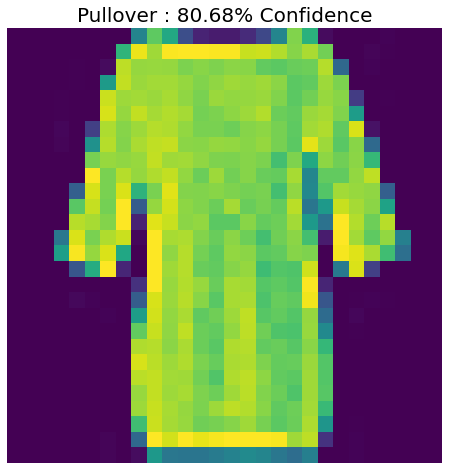

index: 788 Clase: 7 Prob:0.8014673


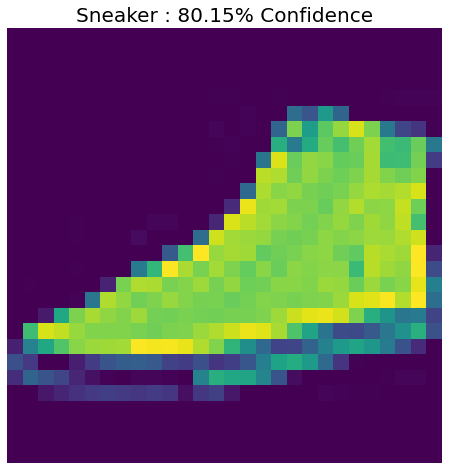

index: 877 Clase: 4 Prob:0.80220306


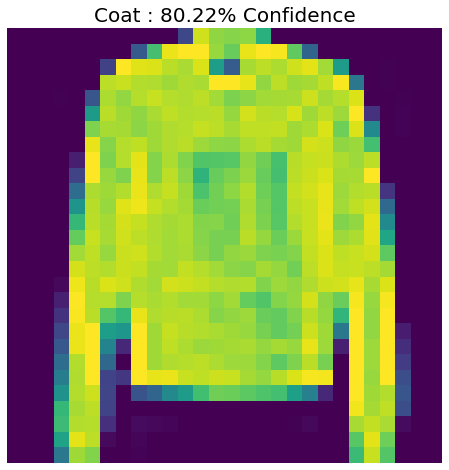

index: 967 Clase: 4 Prob:0.8033605


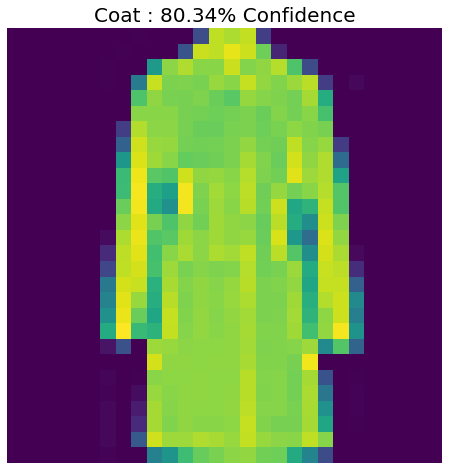

In [341]:
# Se elije la imagen de entrenamiento para crear adversarial example
for i in range(0, 1000):
    index_image2=i #67 dress #997 coat
    image2=x_test[index_image2]
    image_index_class2 = y_test[index_image2]
    image_tf2 = tf.convert_to_tensor(image2, dtype=tf.float32)
    image_tf_a2 = image_tf2[None, ...]
    image_probs2 = model_01.predict(image_tf_a2)
    
    _, image_class2, class_confidence2 = get_imagenet_label(image_probs2)
    label2 = tf.one_hot(image_index_class2, image_probs2.shape[-1]) 
    label2 = tf.reshape(label2, (1, image_probs2.shape[-1]))
    #plt.title('{} : {:.2f}% Confidence'.format(image_class2, class_confidence2*100), fontsize=20)
    #plt.axis(False)
    #plt.show()
    if np.max(image_probs2)*100 <= 83 and np.max(image_probs2)*100 >= 80:
      print("index: " + str(i) + " Clase: " + str(np.argmax(image_probs2)) + " Prob:" + str(np.max(image_probs2)))
      plt.figure()
      plt.imshow(np.squeeze(image_tf_a2[0]))
      plt.title('{} : {:.2f}% Confidence'.format(image_class2, class_confidence2*100), fontsize=20)
      plt.axis(False)
      plt.show()

In [370]:
index_image2=967 #Coat
image2=x_test[index_image2]
image_index_class2 = y_test[index_image2]
image_tf2 = tf.convert_to_tensor(image2, dtype=tf.float32)
image_tf_a2 = image_tf2[None, ...]
image_probs2 = model_01.predict(image_tf_a2)
_, image_class2, class_confidence2 = get_imagenet_label(image_probs2)
label2 = tf.one_hot(image_index_class2, image_probs2.shape[-1]) 
label2 = tf.reshape(label2, (1, image_probs2.shape[-1]))

In [351]:
prediction_x2 = model_01(image_tf_a2)
lost_x2 = loss_object(label2, prediction_x2)
lost_x2

<tf.Tensor: shape=(), dtype=float32, numpy=0.21895163>

(-0.5, 27.5, 27.5, -0.5)

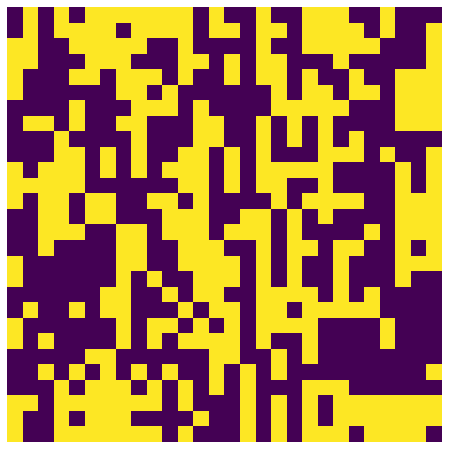

In [352]:
perturbations2 = create_adversarial_pattern(image_tf_a2, label2)
plt.imshow(np.squeeze(perturbations2[0]))
plt.axis(False)

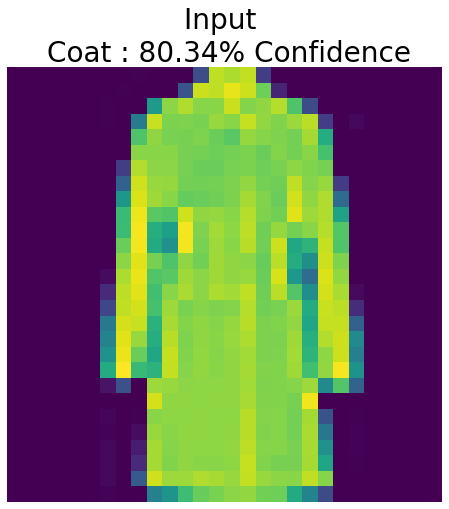

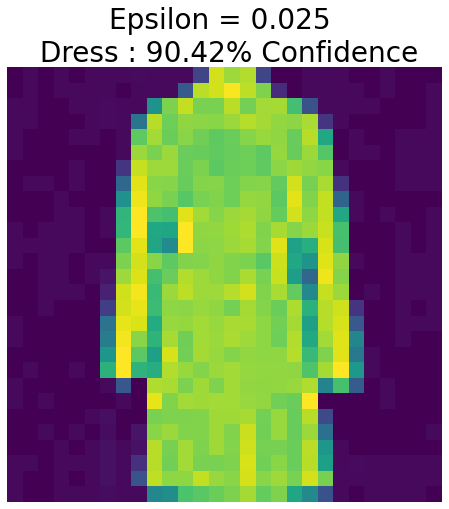

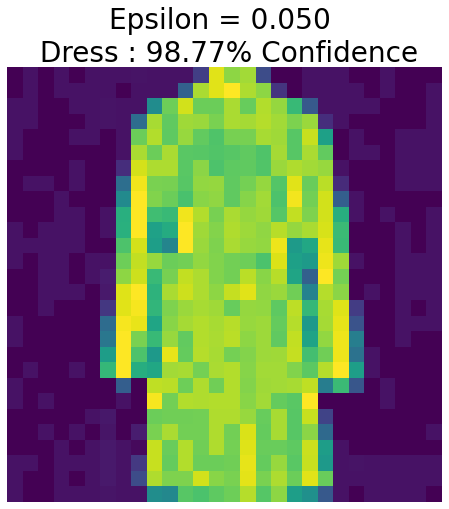

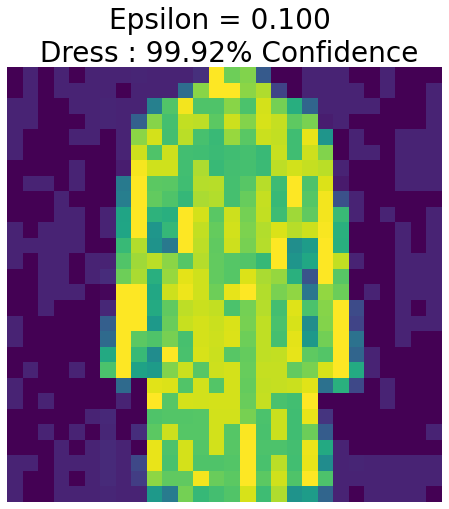

In [369]:
adv_x_arr2 = [] 
for i, eps in enumerate(epsilons):
  adv_x = image_tf_a2 + eps*perturbations2
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i], model_01)
  adv_x_arr2.append(adv_x)

## Ataque 2 al modelo 2

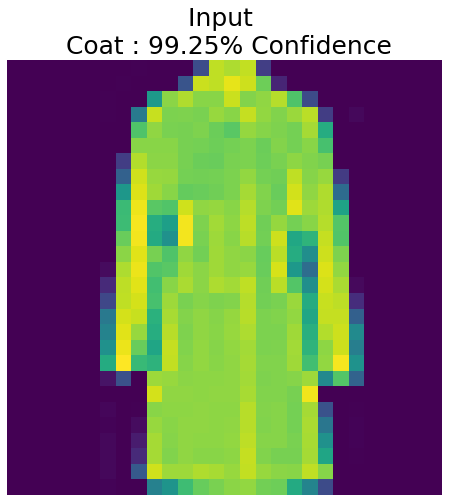

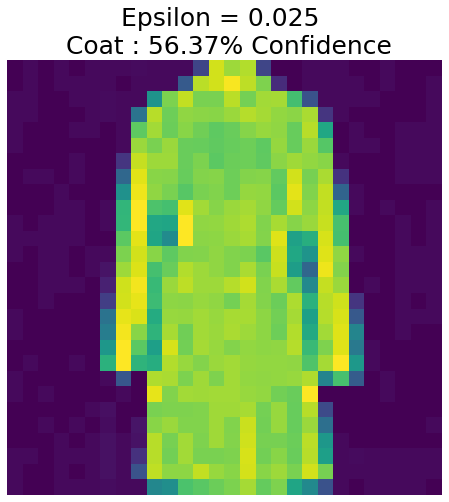

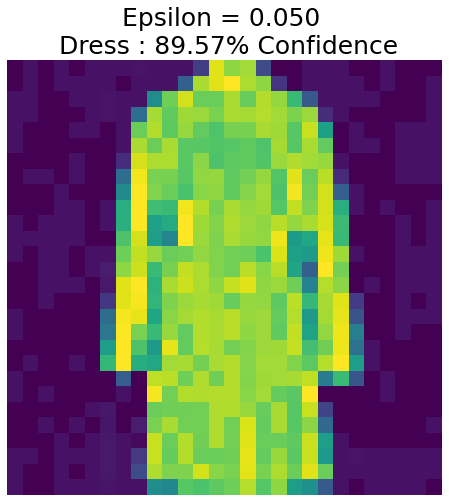

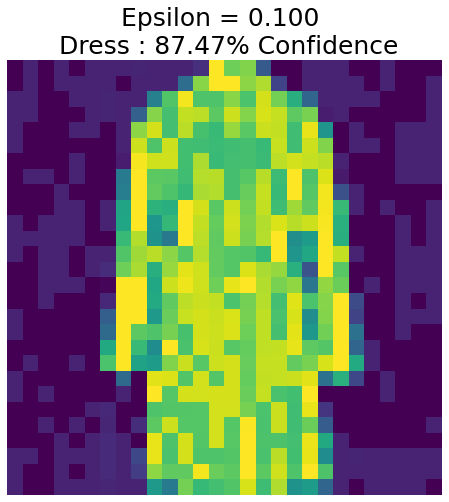

In [354]:
for i in range(len(adv_x_arr2)):
    display_images(adv_x_arr2[i], descriptions[i], model_02)

## Ataque 2 al modelo 3

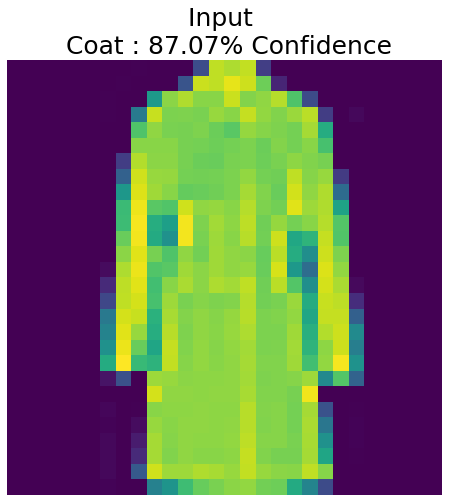

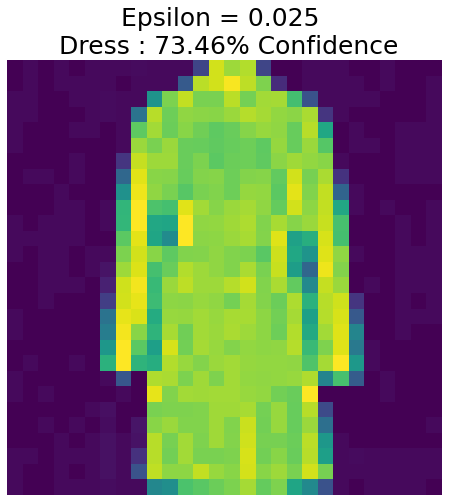

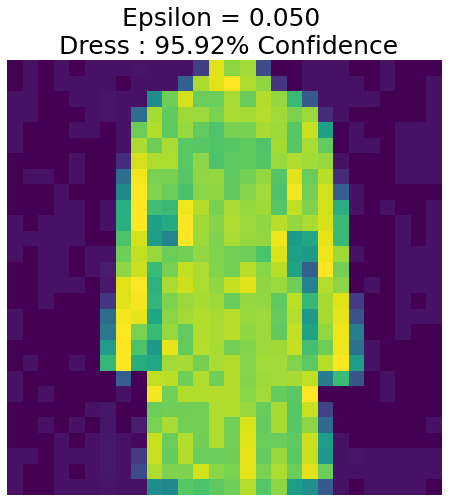

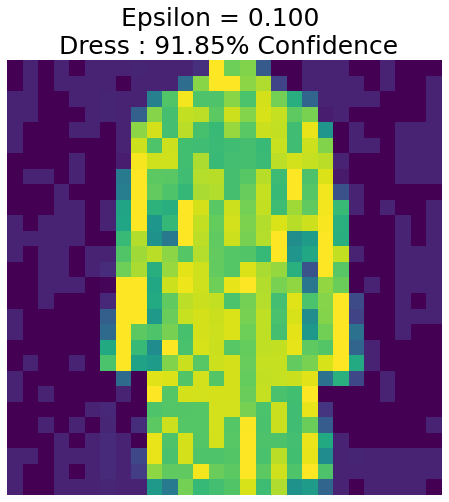

In [356]:
for i in range(len(adv_x_arr2)):
    display_images(adv_x_arr2[i], descriptions[i], model_03)

## Ataque 2 al modelo 4

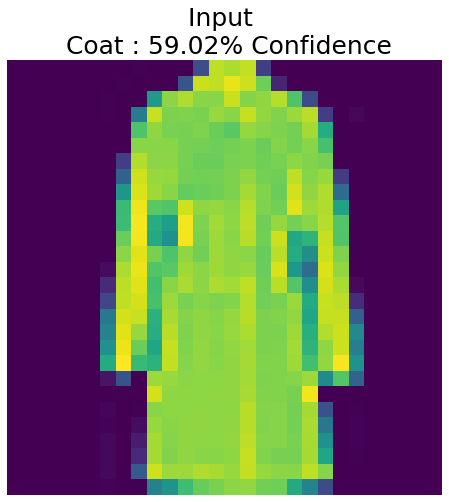

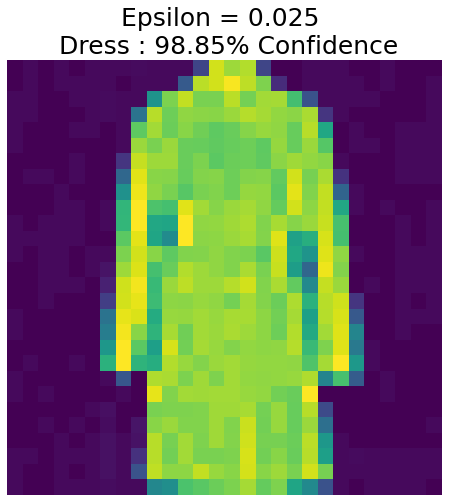

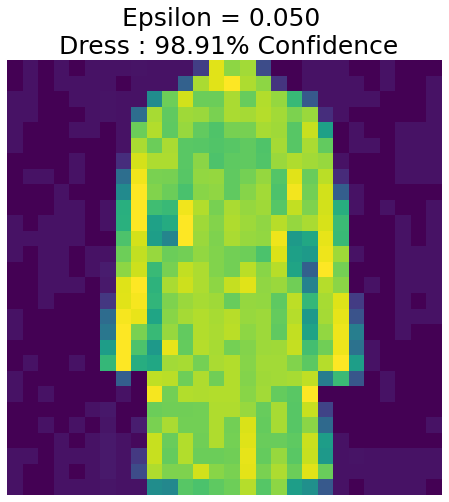

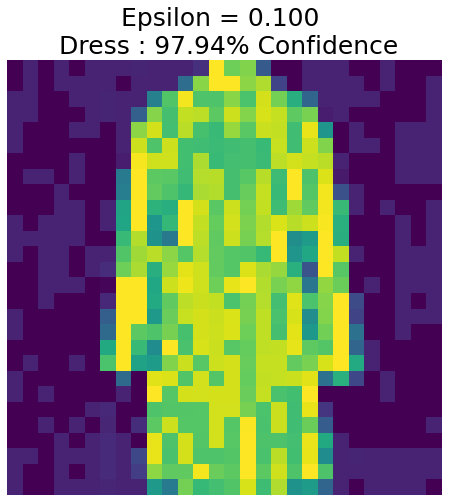

In [358]:
for i in range(len(adv_x_arr2)):
    display_images(adv_x_arr2[i], descriptions[i], model_04)

## Ataque 2 al modelo 5

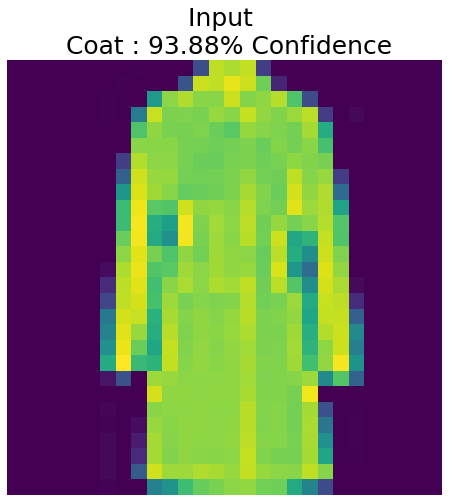

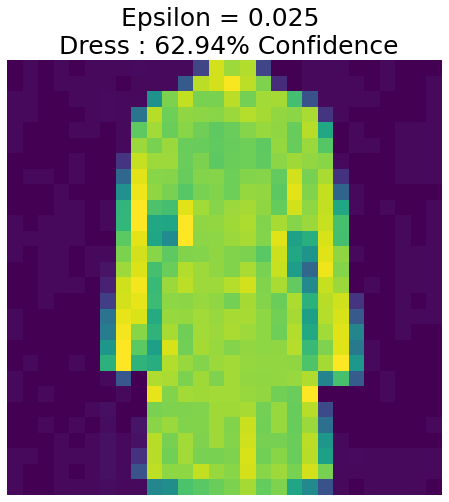

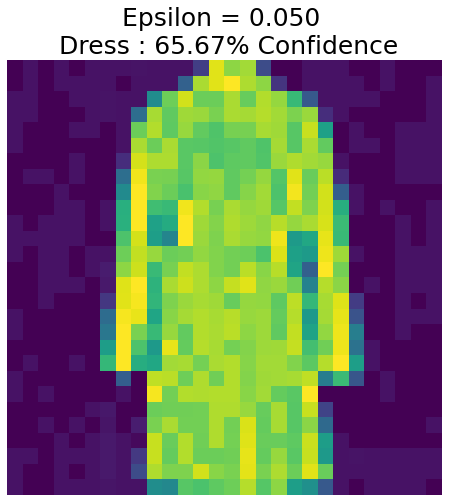

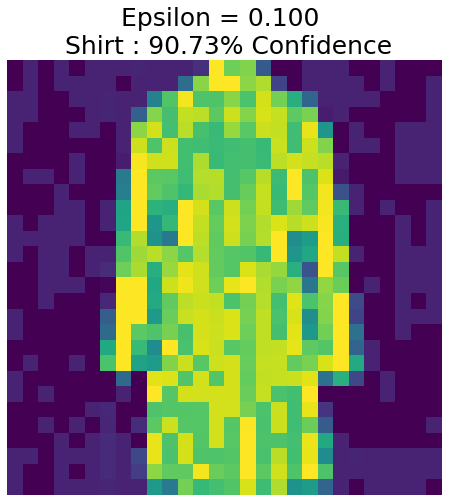

In [360]:
for i in range(len(adv_x_arr2)):
    display_images(adv_x_arr2[i], descriptions[i], model_05)

## Ataque 2 al modelo 6

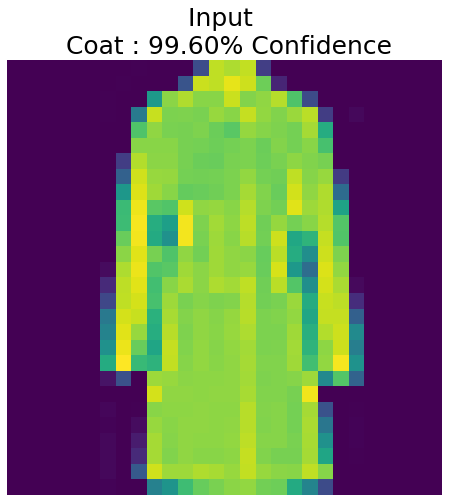

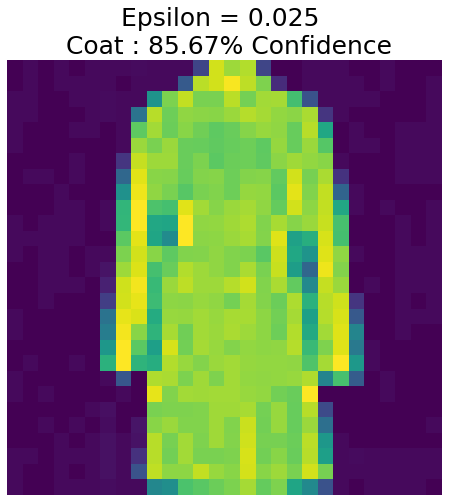

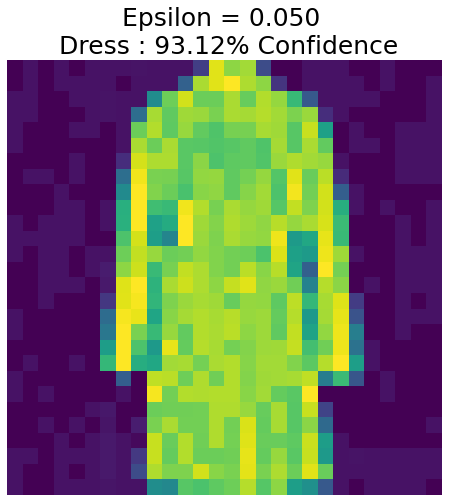

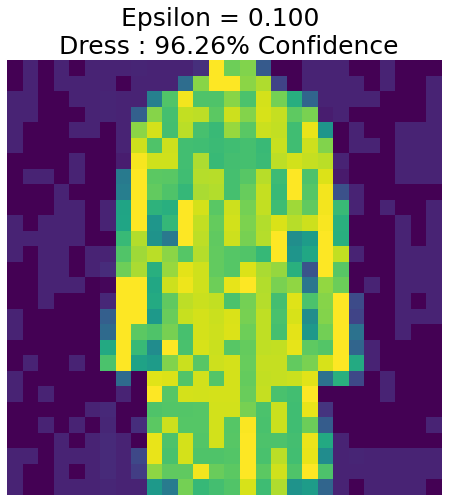

In [362]:
for i in range(len(adv_x_arr2)):
    display_images(adv_x_arr2[i], descriptions[i], model_06)

# Accuracy de modelos

In [179]:
def plot_history_val(histories, key='acc'): #key='sparse_categorical_crossentropy'
  plt.figure(figsize=(16,10))
  max_val = 0
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Test')
    
    if(max_val < max(history.history['val_'+key])):
        max_val = max(history.history['val_'+key])
  y = np.zeros(max(history.epoch)+1) + max_val #recta en maximo 
  plt.plot(history.epoch,y,label=str(max_val))#recta en maximo 
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.xlim([0, max(history.epoch)])
  plt.ylim([0.5, 1])

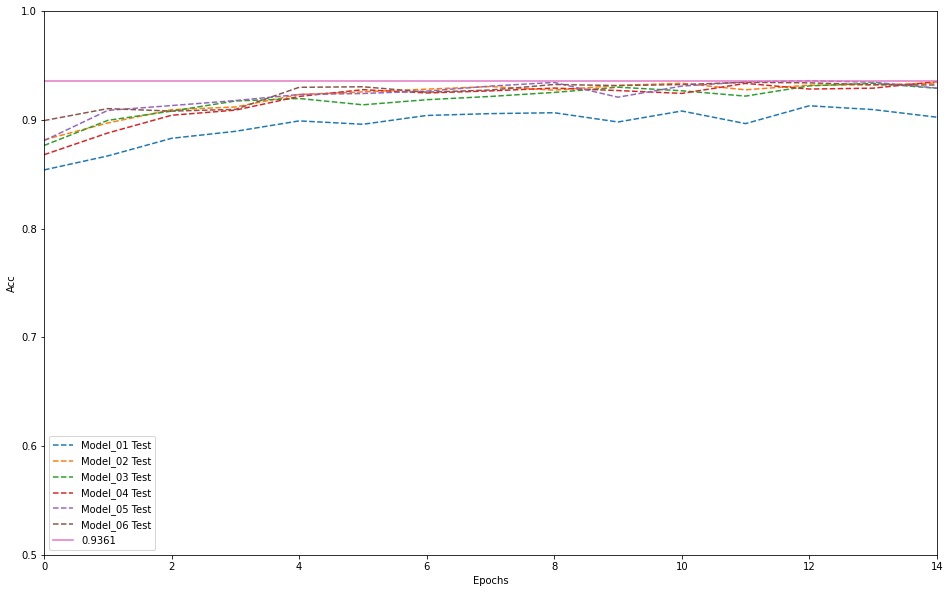

In [59]:
plot_history_val([              
              ('model_01', history_01),
              ('model_02', history_02),
              ('model_03', history_03),
              ('model_04', history_04),
              ('model_05', history_05),
              ('model_06', history_06),
              
			  ])

Gracias!

## Random attack

Generamos 25 perturbaciones aleatorias para distintos valores epsilon y observamos su eficacia en el modelo sustituto como adversarial example

In [97]:
ramdom_attack =  np.arange(25)

ataques = 25
epsilons = [0, 0.05, 0.1, 0.2, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
perturbations_rand = np.zeros((25,1, 28, 28, 1))
for a in range(ataques):
    for i in range(28):
        for j in range(28):
            rand = random.choice([-1.0, 0.0, 1.0])
            perturbations_rand[a][0][i][j][0] = rand
    

In [98]:

print(perturbations_rand[0][0][0][0][0])
print(perturbations_rand[1][0][0][0][0])
print(perturbations_rand[2][0][0][0][0])
print(perturbations_rand[3][0][0][0][0])
print(perturbations_rand[4][0][0][0][0])

1.0
0.0
1.0
0.0
0.0


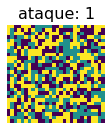

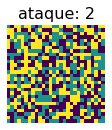

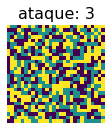

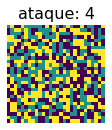

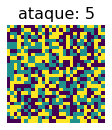

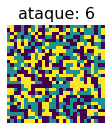

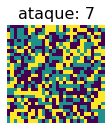

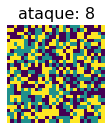

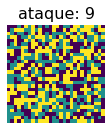

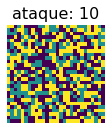

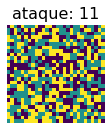

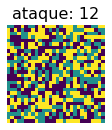

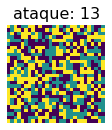

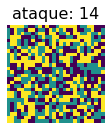

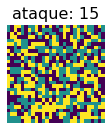

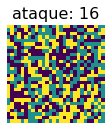

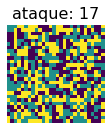

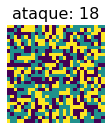

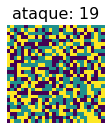

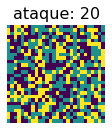

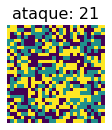

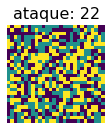

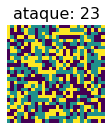

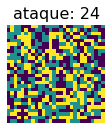

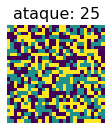

In [101]:
for a in range(ataques):
    
    plt.figure()
    #plt.imshow(image[0])
    plt.title('ataque: '+ str(a + 1), fontsize=16)
    plt.imshow(np.squeeze(perturbations_rand[a]))
    plt.axis(False)
    plt.show()
    
    

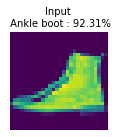

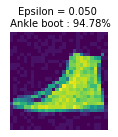

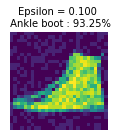

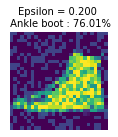

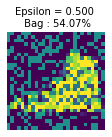

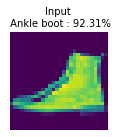

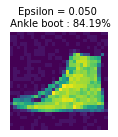

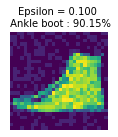

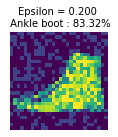

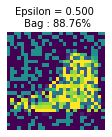

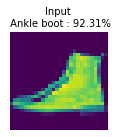

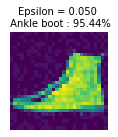

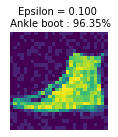

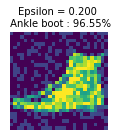

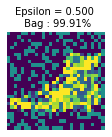

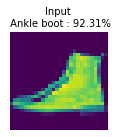

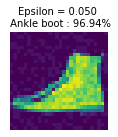

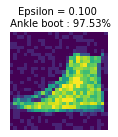

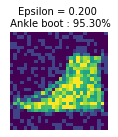

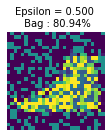

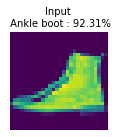

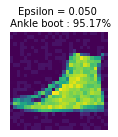

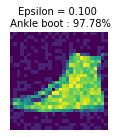

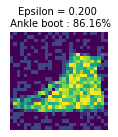

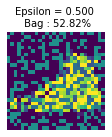

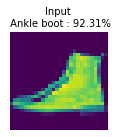

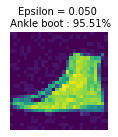

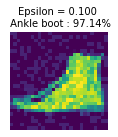

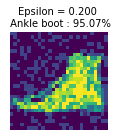

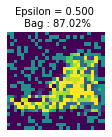

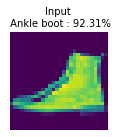

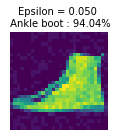

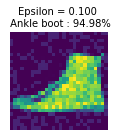

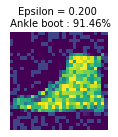

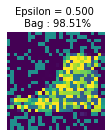

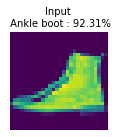

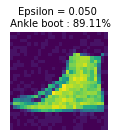

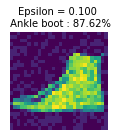

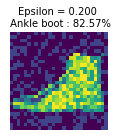

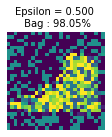

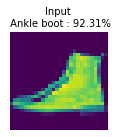

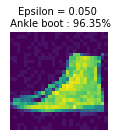

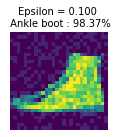

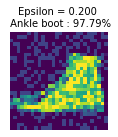

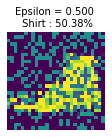

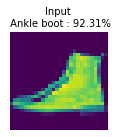

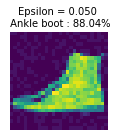

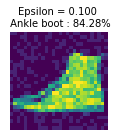

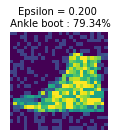

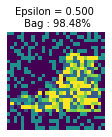

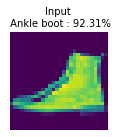

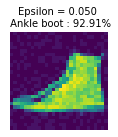

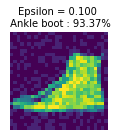

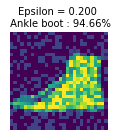

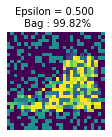

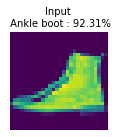

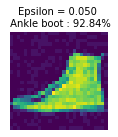

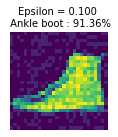

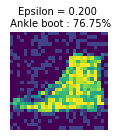

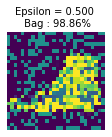

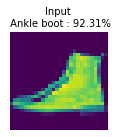

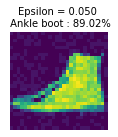

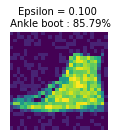

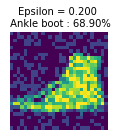

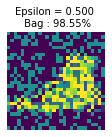

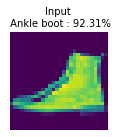

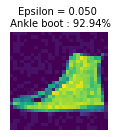

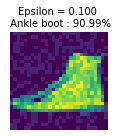

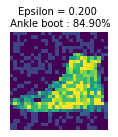

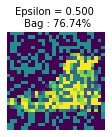

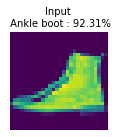

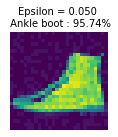

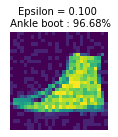

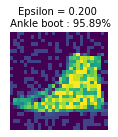

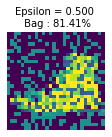

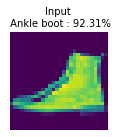

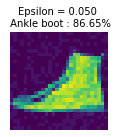

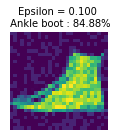

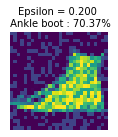

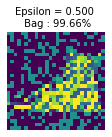

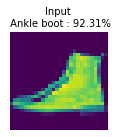

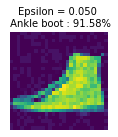

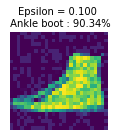

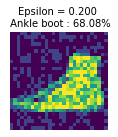

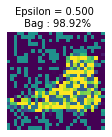

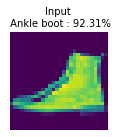

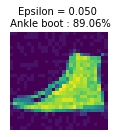

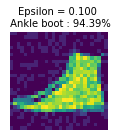

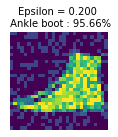

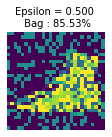

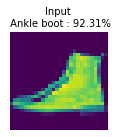

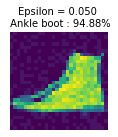

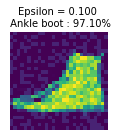

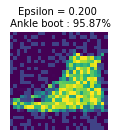

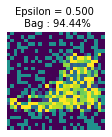

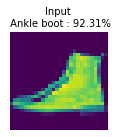

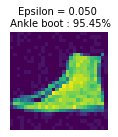

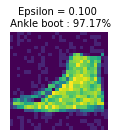

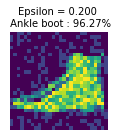

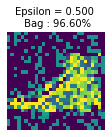

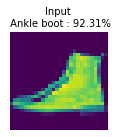

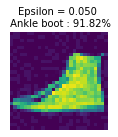

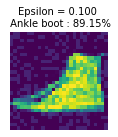

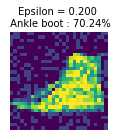

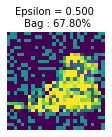

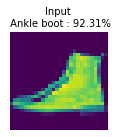

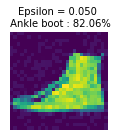

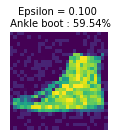

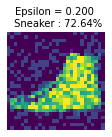

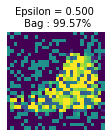

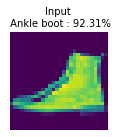

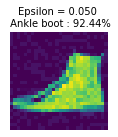

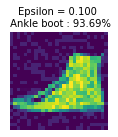

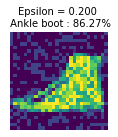

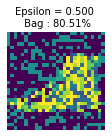

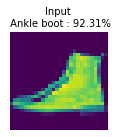

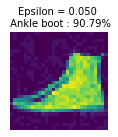

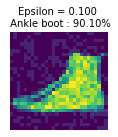

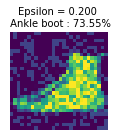

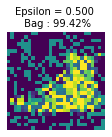

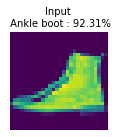

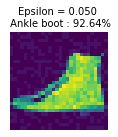

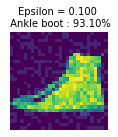

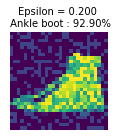

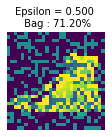

In [102]:
for a in range(ataques):
    print('===================================================================')
    for i, eps in enumerate(epsilons):
      adv_x = image_tf_a + eps*perturbations_rand[a]
      adv_x = tf.clip_by_value(adv_x, 0, 1)
      display_images(adv_x, descriptions[i], model_01)
      adv_x_arr_rand.append(adv_x)